In [157]:
# SETUP CELL

!pip install opencv-python
!pip install dlib
!pip install imutils

import cv2
import numpy as np
import utils
import scipy
import scipy.sparse.linalg
import dlib
import imutils
import matplotlib.pyplot as plt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homeb

In [183]:
# CLASS DEFINITON CELL
class FilterImage:
    def __init__(self, image_path):
        self.filter_img = cv2.imread(image_path)
        self.mask_coords = None
        self.mask = None
        self.features = None
        
    def prompt_set_mask(self):
        import matplotlib.pyplot as plt
        %matplotlib notebook
        self.mask_coords = utils.specify_mask(self.filter_img)
        
    def assign_mask(self):
        %matplotlib inline
        import matplotlib.pyplot as plt
        xs = self.mask_coords[0]
        ys = self.mask_coords[1]
        plt.figure()
        self.mask = utils.get_mask(ys, xs, self.filter_img)
        
    def prompt_feature_selection(self, num_points=3):
        # switch from notebook to inline if using colab or otherwise cannot use interactive display)
        %matplotlib notebook  
        import matplotlib.pyplot as plt
        
        fig = plt.figure()
        plt.imshow(self.filter_img, cmap='gray')
        fig.set_label(f"Click on {num_points} points for alignment")
        plt.axis('off')
        xs = []
        ys = []
        clicked = np.zeros((num_points, 2), dtype=np.float32)

        # Define a callback function that will update the textarea
        def onmousedown(event):
            x = event.xdata
            y = event.ydata
            xs.append(x)
            ys.append(y)

            plt.plot(x, y, 'r-+')
    #         plt.plot(xs, ys, 'r-+')

        def onmouseup(event):
            if(len(xs) >= num_points):
                plt.close(fig)

        def onclose(event):
            clicked[:, 0] = xs
            clicked[:, 1] = ys
        # Create an hard reference to the callback not to be cleared by the garbage
        # collector
        fig.canvas.mpl_connect('button_press_event', onmousedown)
        fig.canvas.mpl_connect('button_release_event', onmouseup)
        fig.canvas.mpl_connect('close_event', onclose)
        
        self.features = clicked
        return clicked


If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


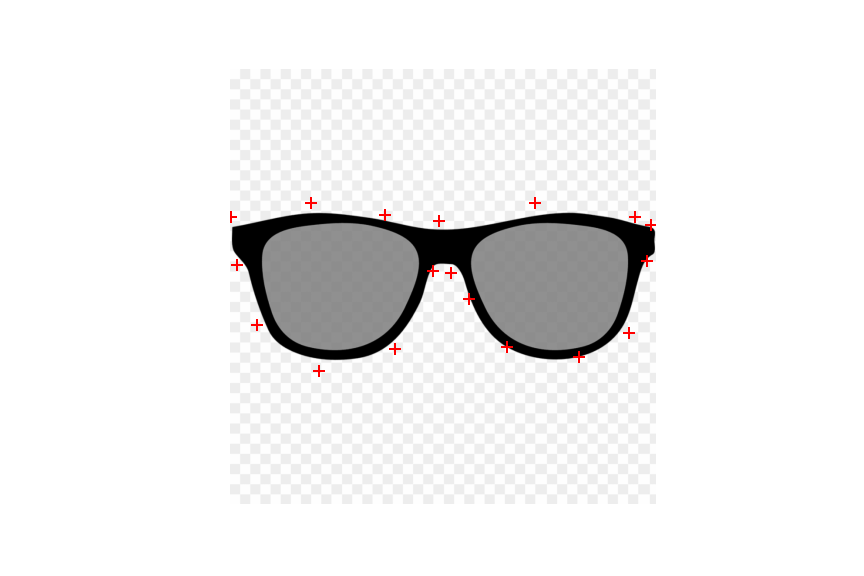

In [186]:
# OBJECT MASK DEFINITION CELL
# Create a mask for the object image. Draw a polygon rougly around the edges of the object, for blending.
img = FilterImage('sunglasses.png')
img.prompt_set_mask()

<Figure size 432x288 with 0 Axes>

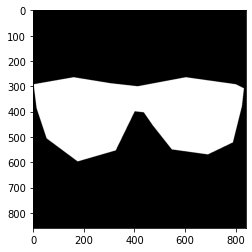

In [187]:
# OBJECT MASK DEFINITION CELL
img.assign_mask()

<IPython.core.display.Javascript object>


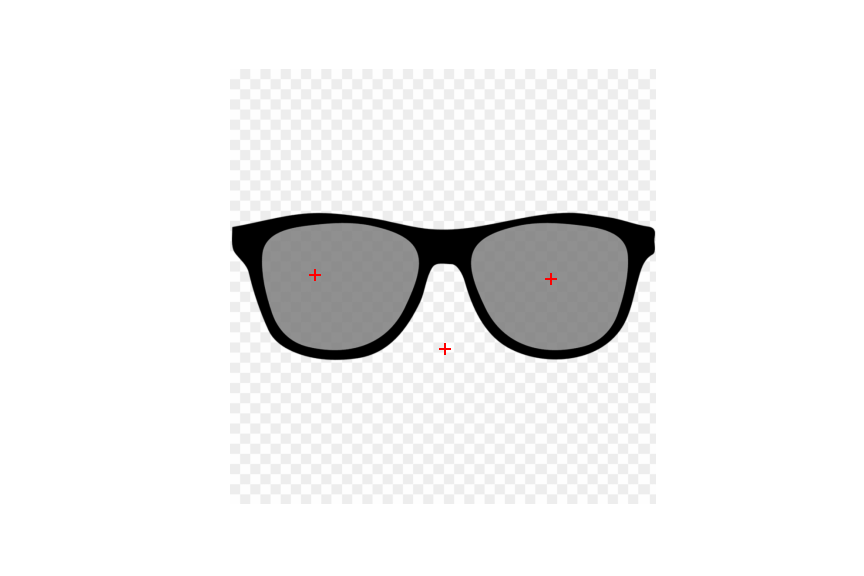

array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [189]:
# OBJECT MASK DEFINITION CELL
# Select the three features on the object that correspond to the Dlib keypoints.
img.prompt_feature_selection()

In [190]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib notebook  
import matplotlib.pyplot as plt

In [198]:
# HELPER FUNCTIONS AND DEFINITIONS

EYE_FEATURES = (37, 28, 43)
MUSTACHE_FEATURES = (48, 51, 54)

def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    return coords

def bounding_box(points):
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)
    return (min_x, min_y, (max_x - min_x), (max_y - min_y))

In [199]:
# CLASS DEFINITON CELL

class ObjectFilter:
    def __init__(self, predictor, object_filter, features = EYE_FEATURES):
        self.predictor = predictor
        self.object_filter = object_filter
        self.features = features

    def set_features(self, features):
        self.features = features
        
    def place_object(self, face):
        facial_features = self.predictor(face, rect)
        facial_features = shape_to_np(facial_features)
                
        f_1, f_2, f_3 = self.features
        print(self.features)
        features = np.array([facial_features[f_1], facial_features[f_2], facial_features[f_3]]).astype('float32')
#         features = np.array([facial_features[39], facial_features[31], facial_features[44]]).astype('float32')
#         features = np.array([facial_features[37], facial_features[28], facial_features[43]]).astype('float32')
#         features = np.array([facial_features[48], facial_features[51], facial_features[54], facial_features[58]]).astype('float32')
        
        plt.figure()
        plt.plot(features[0][0], features[0][1], marker='v', color="white")
        plt.plot(features[1][0], features[1][1], marker='v', color="red")
        plt.plot(features[2][0], features[2][1], marker='v', color="blue")
#         plt.plot(features[3][0], features[3][1], marker='v', color="green")


        plt.imshow(face)

        object_warp, mask_warp = self.get_warps(features.copy(), face)
        
        face = face.astype('double') / 255.0
        im_mix = np.zeros(face.shape)

        for b in np.arange(3):
            im_mix[:,:,b] = self.mixed_blend(object_warp[:,:,b].astype('double') / 255, mask_warp, face[:,:,b].copy(), (0, 0))

        return im_mix
    
    def get_warps(self, features, face):
        start = self.object_filter.features
        end = features
        
#         print(start)
#         print(end)
        
#         M = cv2.getPerspectiveTransform(start, end)
#         warp_object_filter = cv2.warpPerspective(self.object_filter.filter_img, M, face.shape[:2], flags=cv2.INTER_LINEAR)
        
        M = cv2.getAffineTransform(start, end)
        warp_object_filter = cv2.warpAffine(self.object_filter.filter_img, M, face.shape[:2])
        
        object_mask_warp_3d = np.zeros((self.object_filter.mask.shape[0], self.object_filter.mask.shape[1], 3))
        object_mask_warp_3d[:, :, 0] = self.object_filter.mask
#         object_mask_warp = cv2.warpPerspective(object_mask_warp_3d, M, face.shape[:2])[:, :, 0]
        object_mask_warp = cv2.warpAffine(object_mask_warp_3d, M, face.shape[:2])[:, :, 0]
        
        plt.figure()
        plt.imshow(warp_object_filter)
        
        return warp_object_filter, object_mask_warp

    def get_neighbors(self, i, j):
        return [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

    def mixed_blend(self, object_img, object_mask, bg_img, bg_ul):
        """
        Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
        Can be implemented to operate on a single channel or multiple channels
        :param object_img: the image containing the foreground object
        :param object_mask: the mask of the foreground object in object_img
        :param background_img: the background image 
        :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
        """
        #TO DO   
        object_img_shift = np.zeros(bg_img.shape, dtype='double')
        mask_shift = np.zeros(bg_img.shape)

        a, b = np.where(object_mask==1)

        mask_indices = list(zip(a, b))

        im_w, im_h = bg_img.shape
        m = len(mask_indices) * 4
        n = im_w * im_h

        A = scipy.sparse.lil_matrix((m, n))
        b = np.zeros(m)

        print('A shape:', A.shape)

        # Step 2
        im2var = np.arange(im_w * im_h).reshape(im_w, im_h)
        print('im2var shape', im2var.shape)

        e = -1
        for x, y in mask_indices:
            for n_x, n_y in self.get_neighbors(x, y):
                e += 1

                A[e, im2var[x][y]] = 1

                object_grad = object_img[x, y] - object_img[n_x, n_y]
                bg_grad = bg_img[x, y] - bg_img[n_x, n_y]

                grad = object_grad if abs(object_grad) > abs(bg_grad) else bg_grad

                if object_mask[n_x][n_y] == 1:
                    A[e, im2var[n_x][n_y]] = -1
                    b[e] = grad

                else:
                    b[e] = grad + bg_img[n_x, n_y]

        A = scipy.sparse.csr_matrix(A)
        v = scipy.sparse.linalg.lsqr(A, b)[0]

        to_return = bg_img * (1 - object_mask)
    #     v[v<0] = 0
    #     v[v>1] = 1

        for x, y in mask_indices:
            to_return[x, y] += v[im2var[x][y]]
        return to_return
    

In [200]:
# RUN CLASSIFICATION CELL.
dlib_face_detector = dlib.get_frontal_face_detector()
dlib_shape_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

(37, 28, 43)


<IPython.core.display.Javascript object>


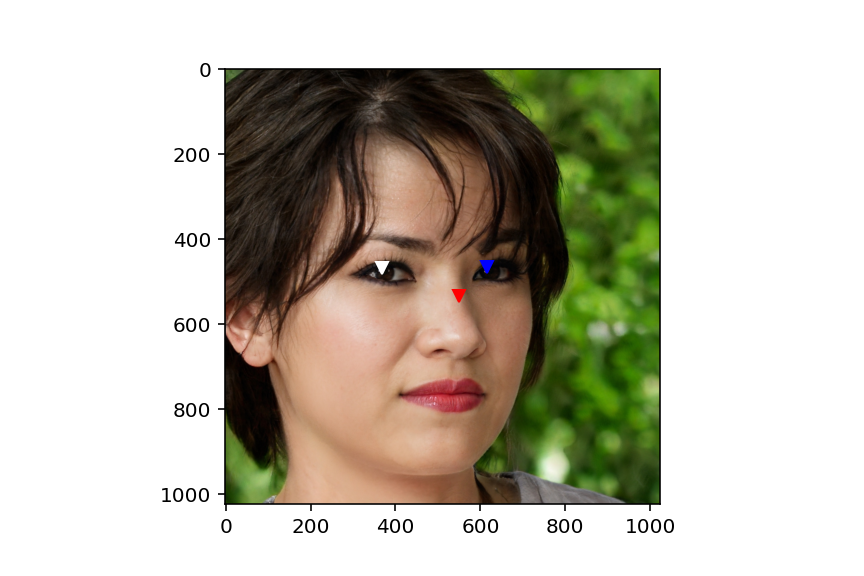

<IPython.core.display.Javascript object>


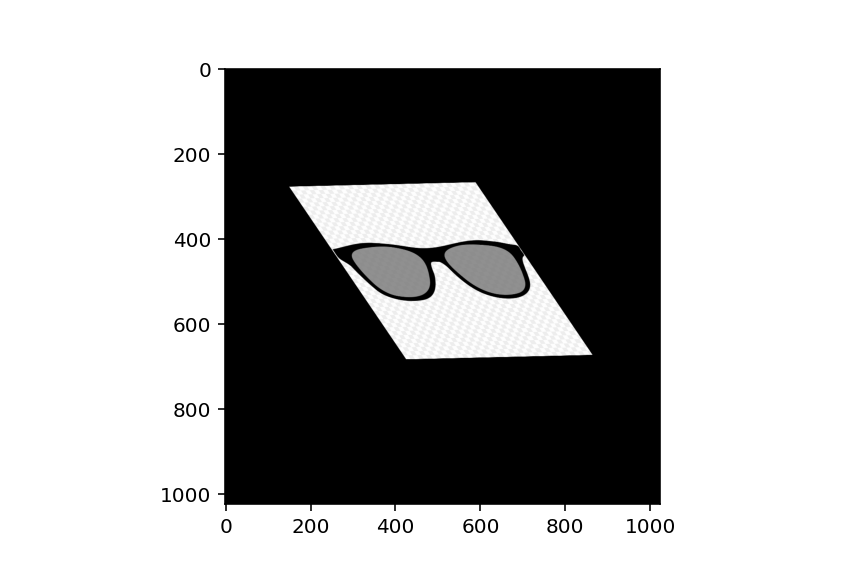

A shape: (195956, 1048576)
im2var shape (1024, 1024)
A shape: (195956, 1048576)
im2var shape (1024, 1024)
A shape: (195956, 1048576)
im2var shape (1024, 1024)


<IPython.core.display.Javascript object>


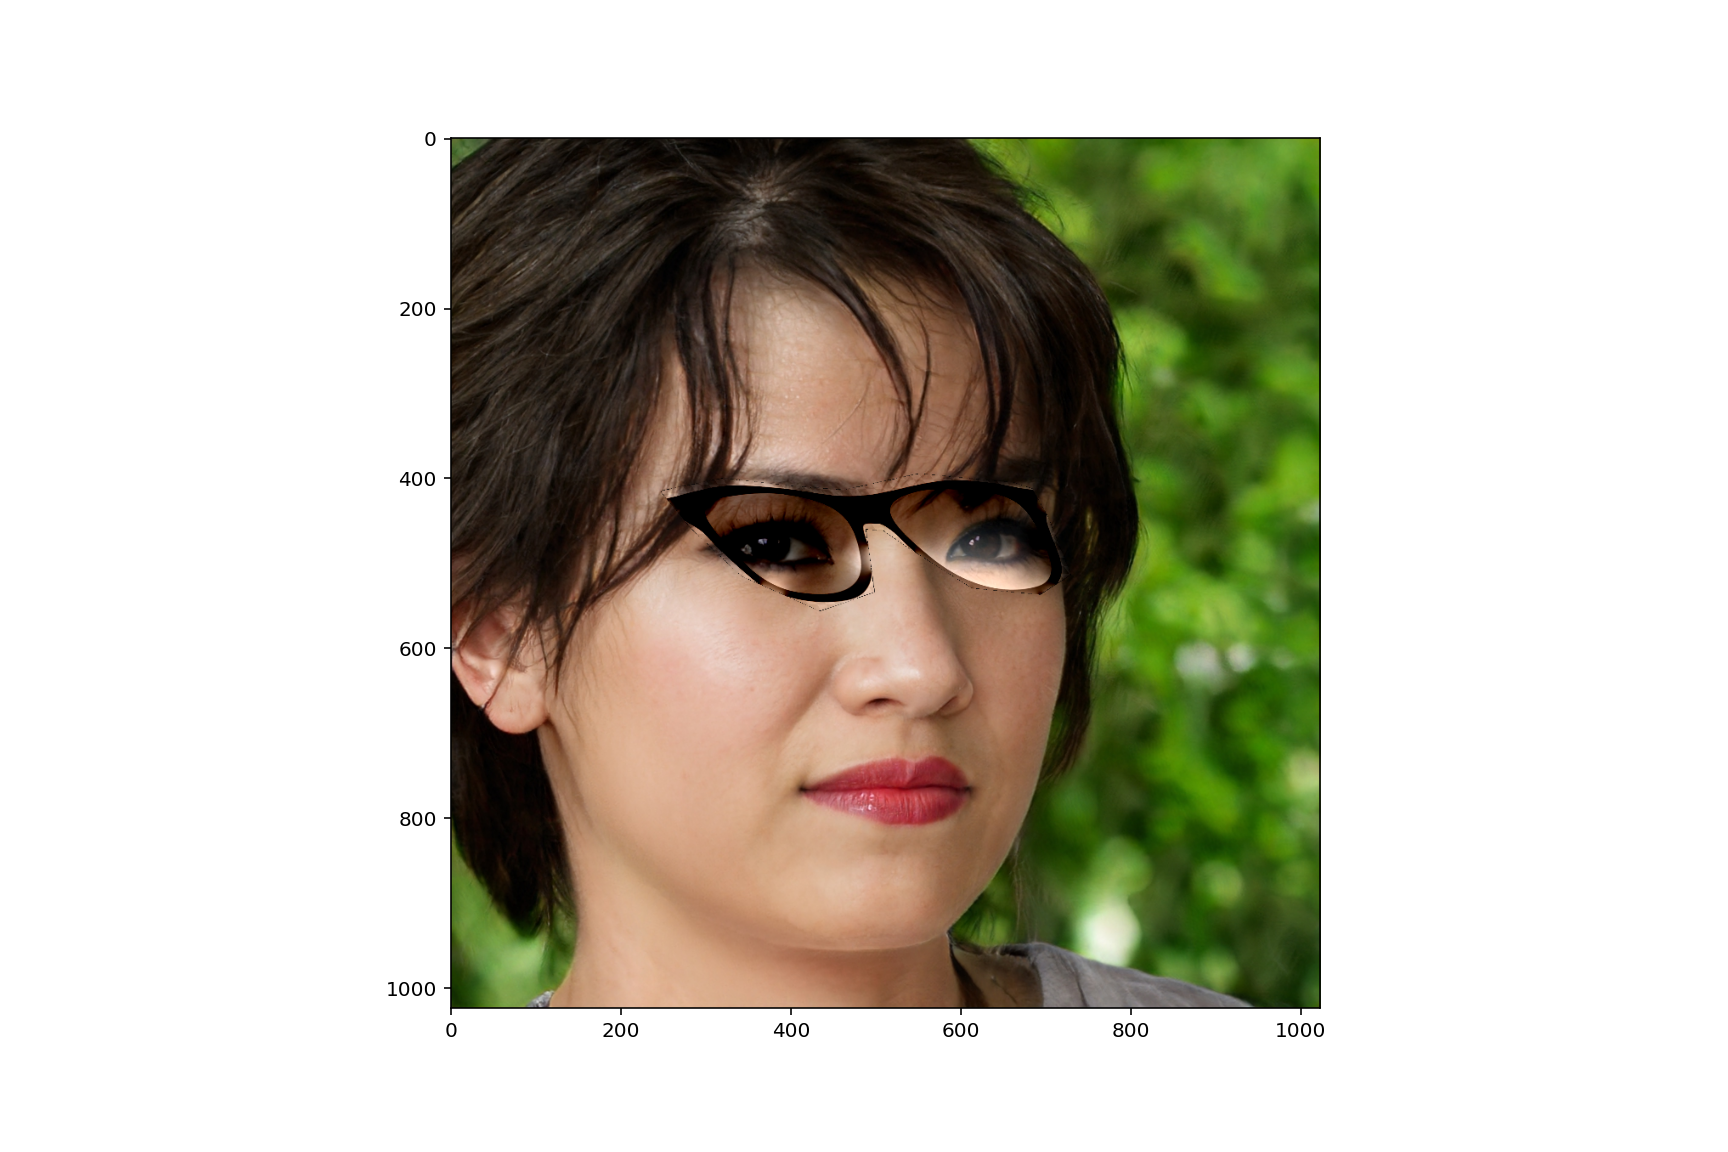

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [203]:
# RUN CLASSIFICATION CELL
# RUN THE FACE DETECTOR, FINDS THE 68 KEY POINST, THEN RUNS THE OBJECT FILTER

face = cv2.cvtColor(cv2.imread('thispersondoesnotexist.jpeg'), cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
rects = dlib_face_detector(gray, 2)
rect = rects[0]

of = ObjectFilter(dlib_shape_predictor, img)
# SET THIS AS NEEDED.
of.set_features(EYE_FEATURES)

output = of.place_object(face)

plt.figure()
plt.imshow(output)

<IPython.core.display.Javascript object>


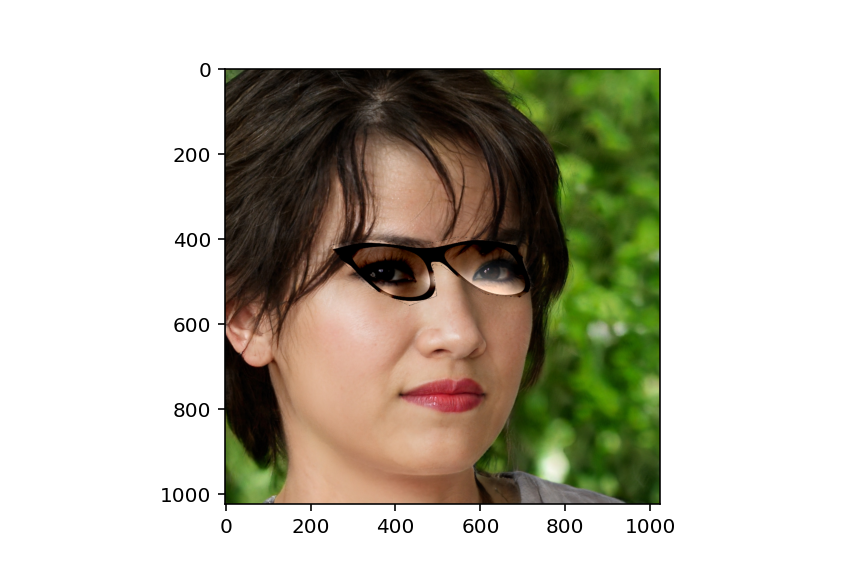

In [202]:
# DISPLAY OUTPUT CELL

output[output > 1] = 1
output[output < 0] = 0

plt.figure()
plt.imshow(output)
plt.imsave('filterGlasses.jpg', output.astype('float'))